# Análisis e interpretación de Datos

###Actividad Grupal: Definición de modelos estadísticos.

##Objetivo

Analizar la información referente al desarrollo de la pandemia en México y Perú, para determinar si los procesos de vacunación tienen o no un efecto positivo en la disminución de defunciones. Así como analizar si las reestricciones impuestas por los gobiernos de cada país tuvieron un impacto en la reducción de contagios o muertes.

La información utilizada para este análisis, se encuentra en el repositorio público "COVID-19 Dataset by Our World in Data",el cual mantiene información actualizada de diferentes países.

In [ ]:
#@title Importar bibliotecas y lectura de fuente de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import scipy as sp


url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
globalcovid = pd.read_csv(url, index_col=0)

Dado que este análisis es solo para comparar el comportamiento entre México y Perú, únicamente se filtra la información para estos paises, se crean datos como el "Año", "Mes" y "Semana" para poder agrupar por estos campos y se obtienen solo los campos a analizar. 

En este caso se agrupa la información por país, año y semana para segmentar la información.

In [ ]:
#@title Limpieza y transformación
#Filtrar por paises
searchcountries = ['Peru', 'Mexico']

mexpercovid = globalcovid[['location', 'date', 'population', 'total_cases',
                           'new_cases', 'total_deaths', 'new_deaths', 
                           'total_vaccinations', 'people_vaccinated', 
                           'people_fully_vaccinated', 'new_vaccinations', 
                           'stringency_index', 'human_development_index']
             ].loc[globalcovid['location'].isin(searchcountries)]

#Convertir a fecha y contruir campos para agrupaciones
mexpercovid['date'] = pd.to_datetime(mexpercovid['date'])
mexpercovid[['population', 'total_cases', 'new_cases', 'total_deaths', 
             'new_deaths', 'total_vaccinations', 'people_vaccinated', 
             'people_fully_vaccinated', 'new_vaccinations']] = mexpercovid[['population', 
             'total_cases', 'new_cases', 'total_deaths', 
             'new_deaths', 'total_vaccinations', 'people_vaccinated', 
             'people_fully_vaccinated', 'new_vaccinations']].fillna(0).astype(int)
mexpercovid['year'], mexpercovid['month'], mexpercovid['week'], mexpercovid['yearweek'] = mexpercovid['date'].dt.year, mexpercovid['date'].dt.month, mexpercovid['date'].dt.isocalendar().week, mexpercovid['date'].dt.to_period('W')
 

#Obtener únicamente los campos utilizados en este análisis, agrupados por país, año
covidrestmex = mexpercovid.groupby(['location', 'yearweek']).agg({'stringency_index': 'max', 'new_cases':'sum','new_deaths':'sum', 'new_vaccinations': 'sum'}).reset_index()

covidrestmex = covidrestmex.replace(0, np.NaN)

#Normalización de valores
x = covidrestmex[['new_cases', 'new_deaths', 'new_vaccinations']].values #returns a numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.rename(columns = {0: 'Activos', 1: 'Defunciones', 2: 'Vacunados'}, inplace=True)
df

covidrestmex = pd.concat([covidrestmex, df], axis=1)

In [ ]:
#@title Dataframe Resultado:
covidrestmex.to_csv('covidmexper.csv')

In [ ]:
#@title Crear un dataframe por cada país
#Filtrar datasets por país y año
covidrestmex1 = covidrestmex.loc[(covidrestmex['location'] == 'Mexico') & (covidrestmex['yearweek'].astype(str).str[0:4].astype(int) >= 2021)]
covidrestper = covidrestmex.loc[(covidrestmex['location'] == 'Peru') & (covidrestmex['yearweek'].astype(str).str[0:4].astype(int) >= 2021)]
covid2021 = covidrestmex.loc[(covidrestmex['yearweek'].astype(str).str[0:4].astype(int) >= 2021)]


En esta conjunto de datos, podemos ver que durante el año 2021, se registraron en promedio por semana 39,398 casos para Perú y 62,166 casos para México, así como el promedio de defunciones por semana que fue de 1,999 para Perú y 3,114 para México. Cada país con un promedio semanal de vacunados de 1,086,372 y de 2,387,685 respectivamente para Perú y México. Desafortunadamente, se tuvieron picos máximos de 4,062 defunciones en una semana para Perú y de 8,922 defunciones en una semana para México.

In [ ]:
#@title Análisis numérico en México
covidrestmex1.describe()

,stringency_index,new_cases,new_deaths,new_vaccinations,Activos,Defunciones,Vacunados
count,56.000000,56.000000,56.000000,5.600000e+01,56.000000,56.000000,56.000000
mean,47.387321,62166.321429,3114.428571,2.387685e+06,0.182824,0.348927,0.249791
std,13.741844,61265.019354,2174.486513,1.968928e+06,0.180179,0.243777,0.206393
min,31.480000,14681.000000,785.000000,4.753000e+03,0.043171,0.087780,0.000000
25%,35.190000,20817.000000,1360.250000,7.915248e+05,0.061216,0.152270,0.082474
50%,44.440000,39038.500000,2409.500000,2.260792e+06,0.114805,0.269899,0.236490
75%,61.575000,86308.250000,4231.500000,3.636618e+06,0.253825,0.474159,0.380711
max,71.760000,299515.000000,8922.000000,9.544438e+06,0.880861,1.000000,1.000000


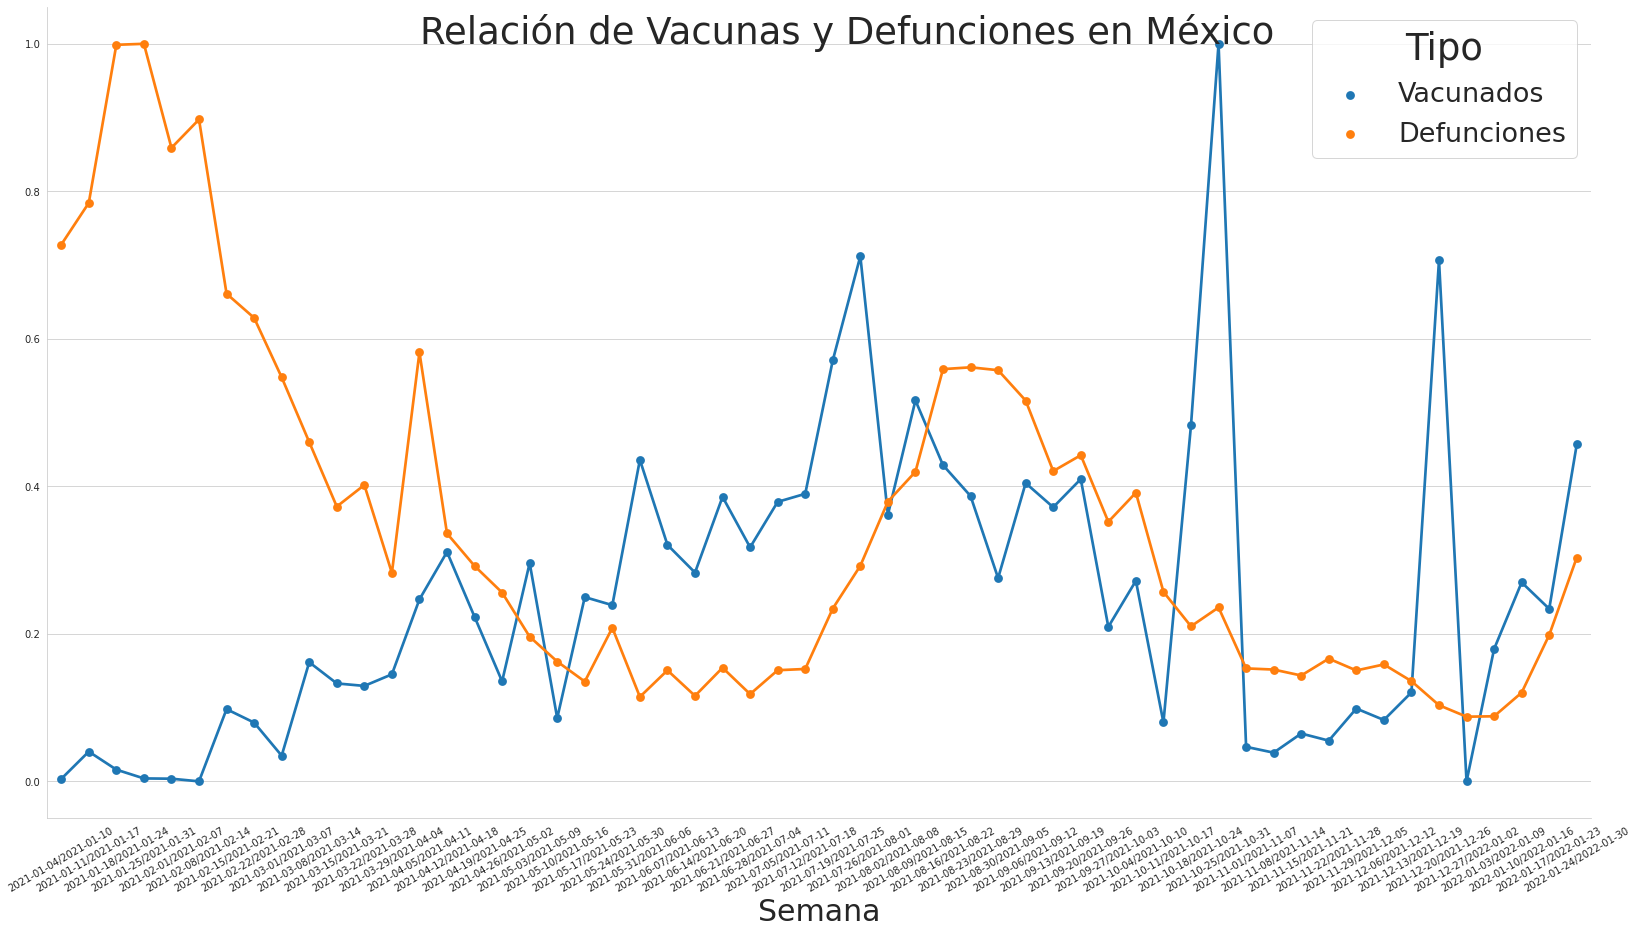

In [ ]:
#@title Relación de vacunas y defunciones en México
dfm = covidrestmex1[['yearweek', 'Vacunados', 'Defunciones']].melt('yearweek', var_name='cols', value_name='vals')

dfm.rename(columns = {'yearweek': 'Semana', 'cols': 'Tipo'}, inplace=True)
sns.set_style("whitegrid")
g = sns.catplot(x="Semana", 
                y="vals", 
                hue='Tipo', 
                data=dfm, 
                kind='point',
                height=12, aspect=15/8)
g.set_axis_labels("Semana", "", fontsize=30)
g.fig.suptitle('Relación de Vacunas y Defunciones en México', fontsize=37)
g.set_xticklabels(rotation=30)
g._legend.remove()

plt.legend(title='Tipo', fontsize='27', title_fontsize='37')

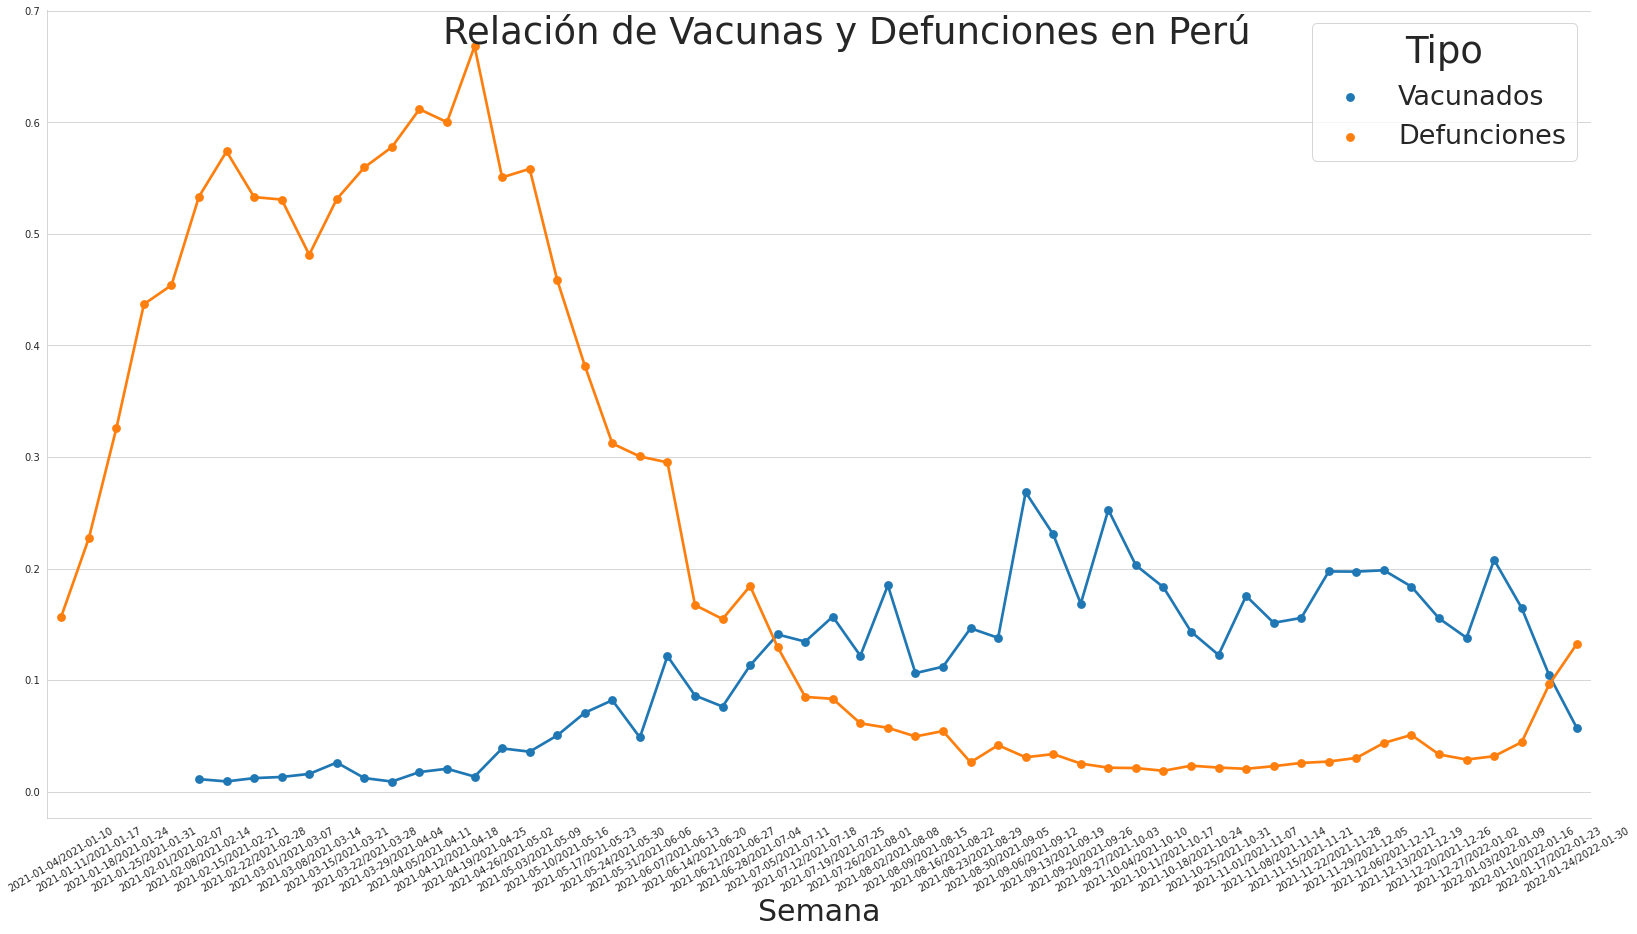

In [ ]:
#@title Relación de vacunas y defunciones en Perú
dfm = covidrestper[['yearweek', 'Vacunados', 'Defunciones']].melt('yearweek', var_name='cols', value_name='vals')

dfm.rename(columns = {'yearweek': 'Semana', 'cols': 'Tipo'}, inplace=True)
sns.set_style("whitegrid")
g = sns.catplot(x="Semana", 
                y="vals", 
                hue='Tipo', 
                data=dfm, 
                kind='point',
                height=12, aspect=15/8)
g.set_axis_labels("Semana", "", fontsize=30)
g.set_xticklabels(rotation=30)
g.fig.suptitle('Relación de Vacunas y Defunciones en Perú', fontsize=37)
g._legend.remove()

plt.legend(title='Tipo', fontsize='27', title_fontsize='37')

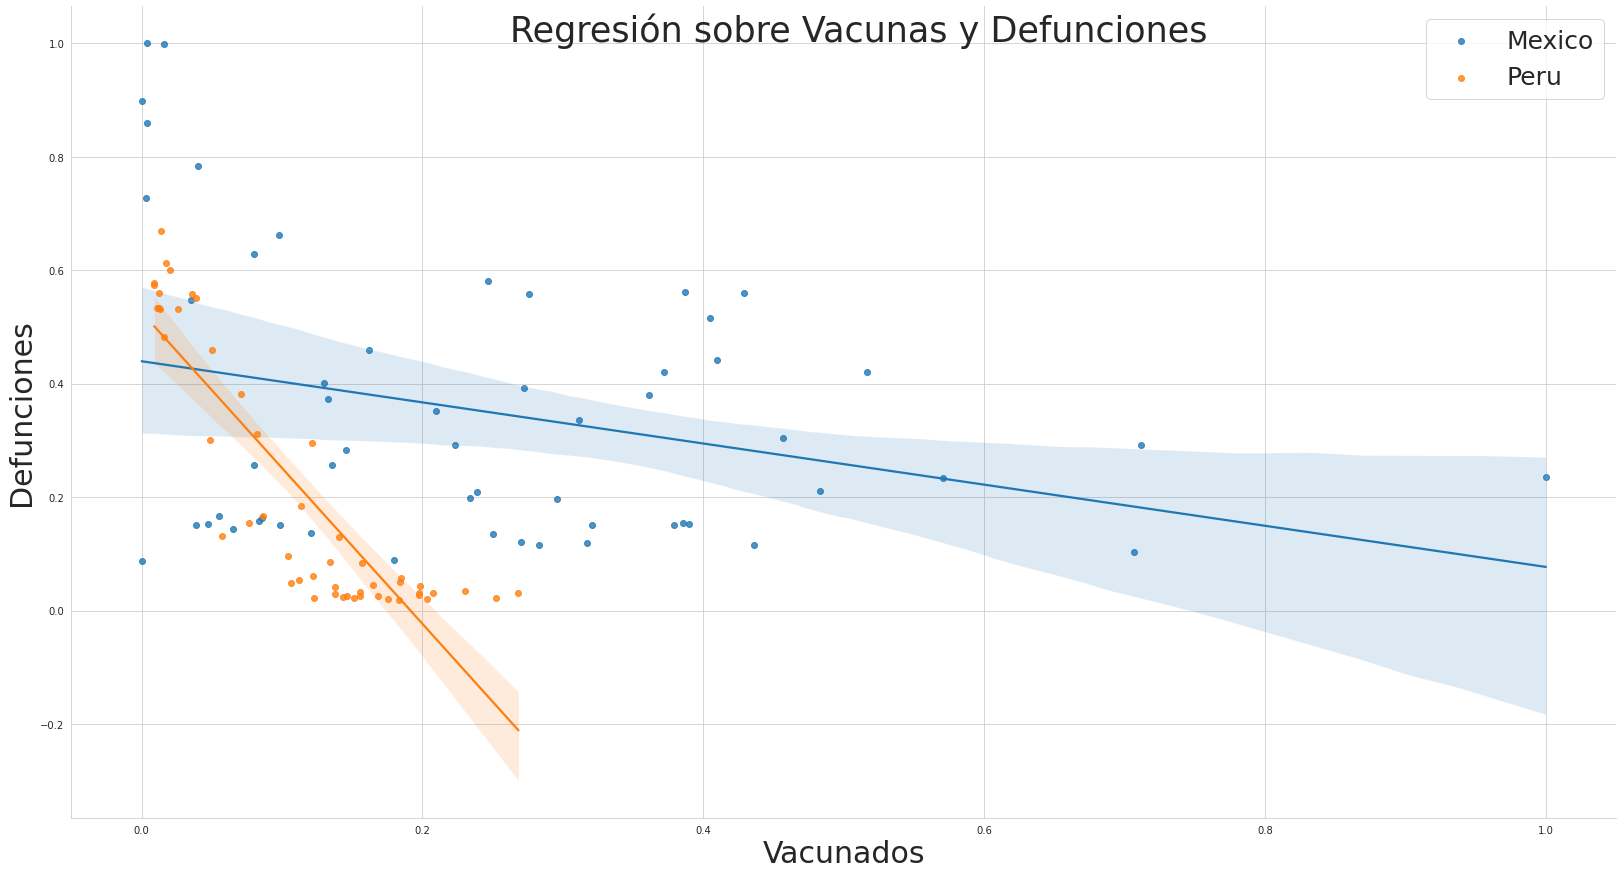

In [ ]:
#@title Regresión sobre el efecto de las vacunas con las defunciones
#dfm.rename(columns = {'week': 'Semana', 'cols': 'Tipo'}, inplace=True)
sns.set_style("whitegrid")
g = sns.lmplot(x="Vacunados", 
               y="Defunciones", 
               data=covid2021, 
               #x_estimator=np.mean, 
               hue='location',
               height=12, aspect=15/8)
g.set_axis_labels("Vacunados", "Defunciones", fontsize=30)
g.fig.suptitle('Regresión sobre Vacunas y Defunciones', fontsize=35)
g._legend.remove()

plt.legend(title='', fontsize='25', title_fontsize='27')



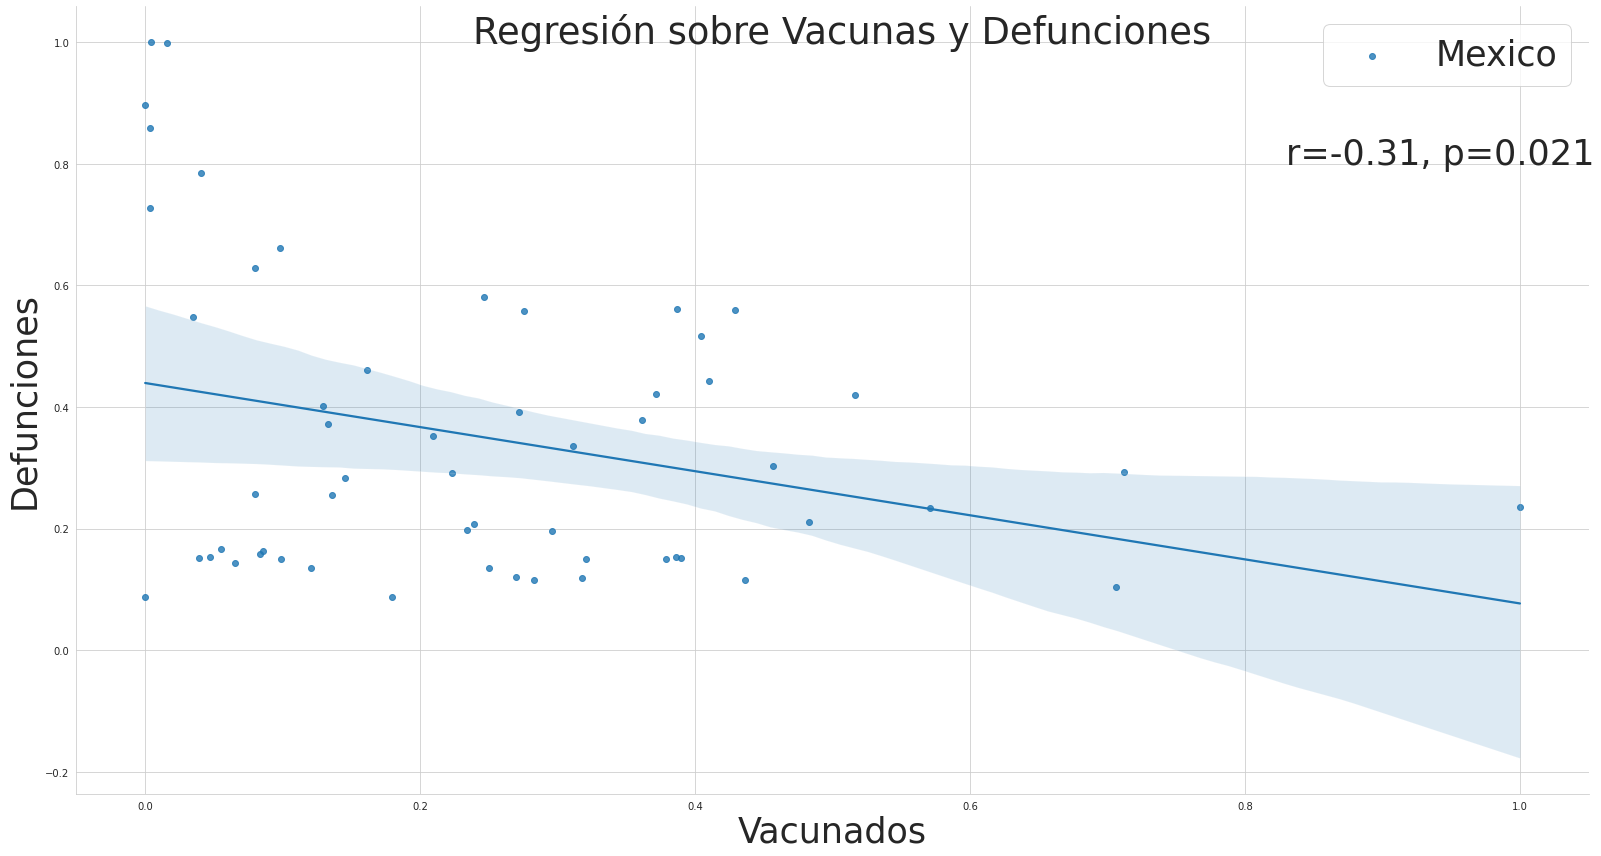

In [ ]:
#@title Regresión sobre el efecto de las vacunas con las defunciones en México
#dfm.rename(columns = {'week': 'Semana', 'cols': 'Tipo'}, inplace=True)
#def r2(x, y):
#    return sp.pearsonr(x, y)[0] ** 2
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(covidrestmex1['Vacunados'].fillna(0), covidrestmex1['Defunciones'].fillna(0))
    ax = plt.gca()
    ax.text(x=.8, 
            y=.8, 
            s='r={:.2f}, p={:.2g}'.format(r, p),
            fontsize=35,
            transform=ax.transAxes)
    
sns.set_style("whitegrid")
g = sns.lmplot(x="Vacunados", 
               y="Defunciones", 
               data=covidrestmex1, 
               #x_estimator=np.mean, 
               hue='location',
               #kind='reg',
               height=12, aspect=15/8)
g.set_axis_labels("Vacunados", "Defunciones", fontsize=35)
g.fig.suptitle('Regresión sobre Vacunas y Defunciones', fontsize=37)
g._legend.remove()
g.map_dataframe(annotate)

plt.legend(title='', fontsize='35', title_fontsize='37')


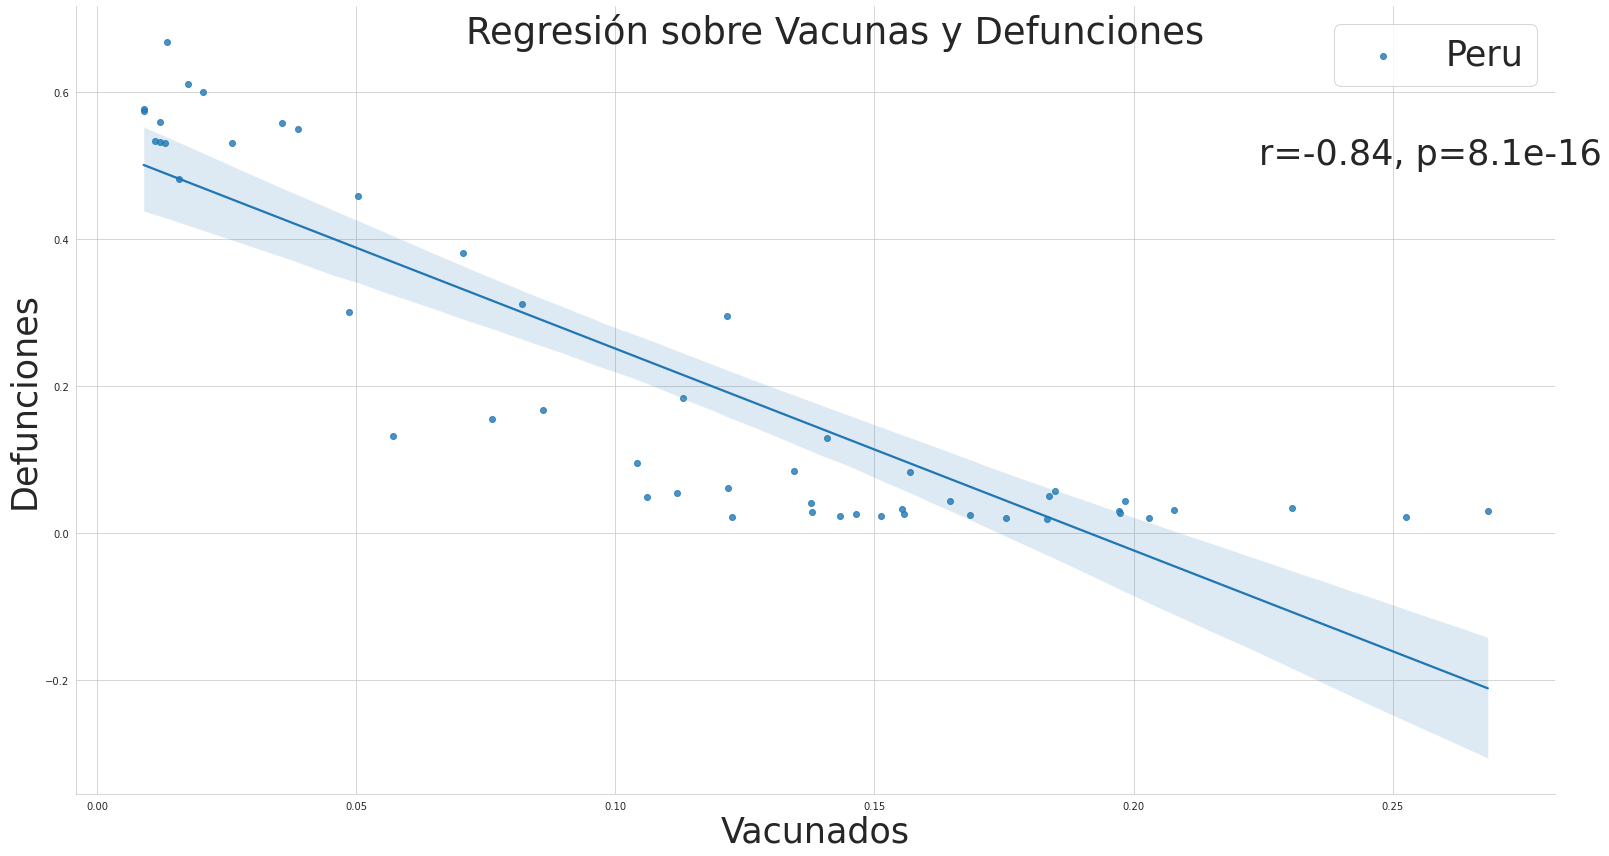

In [ ]:
#@title Regresión sobre el efecto de las vacunas con las defunciones en Perú
#dfm.rename(columns = {'week': 'Semana', 'cols': 'Tipo'}, inplace=True)
sns.set_style("whitegrid")

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(covidrestper['Vacunados'].fillna(0), covidrestper['Defunciones'].fillna(0))
    ax = plt.gca()
    ax.text(x=.8, 
            y=.8, 
            s='r={:.2f}, p={:.2g}'.format(r, p),
            fontsize=35,
            transform=ax.transAxes)
    

g = sns.lmplot(x="Vacunados", 
               y="Defunciones", 
               data=covidrestper, 
               #x_estimator=np.mean, 
               hue='location',
               height=12, aspect=15/8)
g.set_axis_labels("Vacunados", "Defunciones", fontsize=35)
g.fig.suptitle('Regresión sobre Vacunas y Defunciones', fontsize=37)
g._legend.remove()
g.map_dataframe(annotate)

plt.legend(title='', fontsize='35', title_fontsize='37')

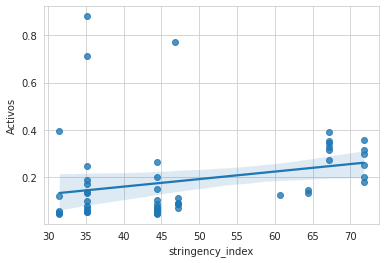

In [ ]:
sns.regplot(x="stringency_index", y="Activos", data=covidrestmex1);

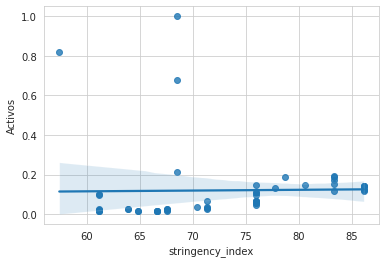

In [ ]:
sns.regplot(x="stringency_index", y="Activos", data=covidrestper);

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


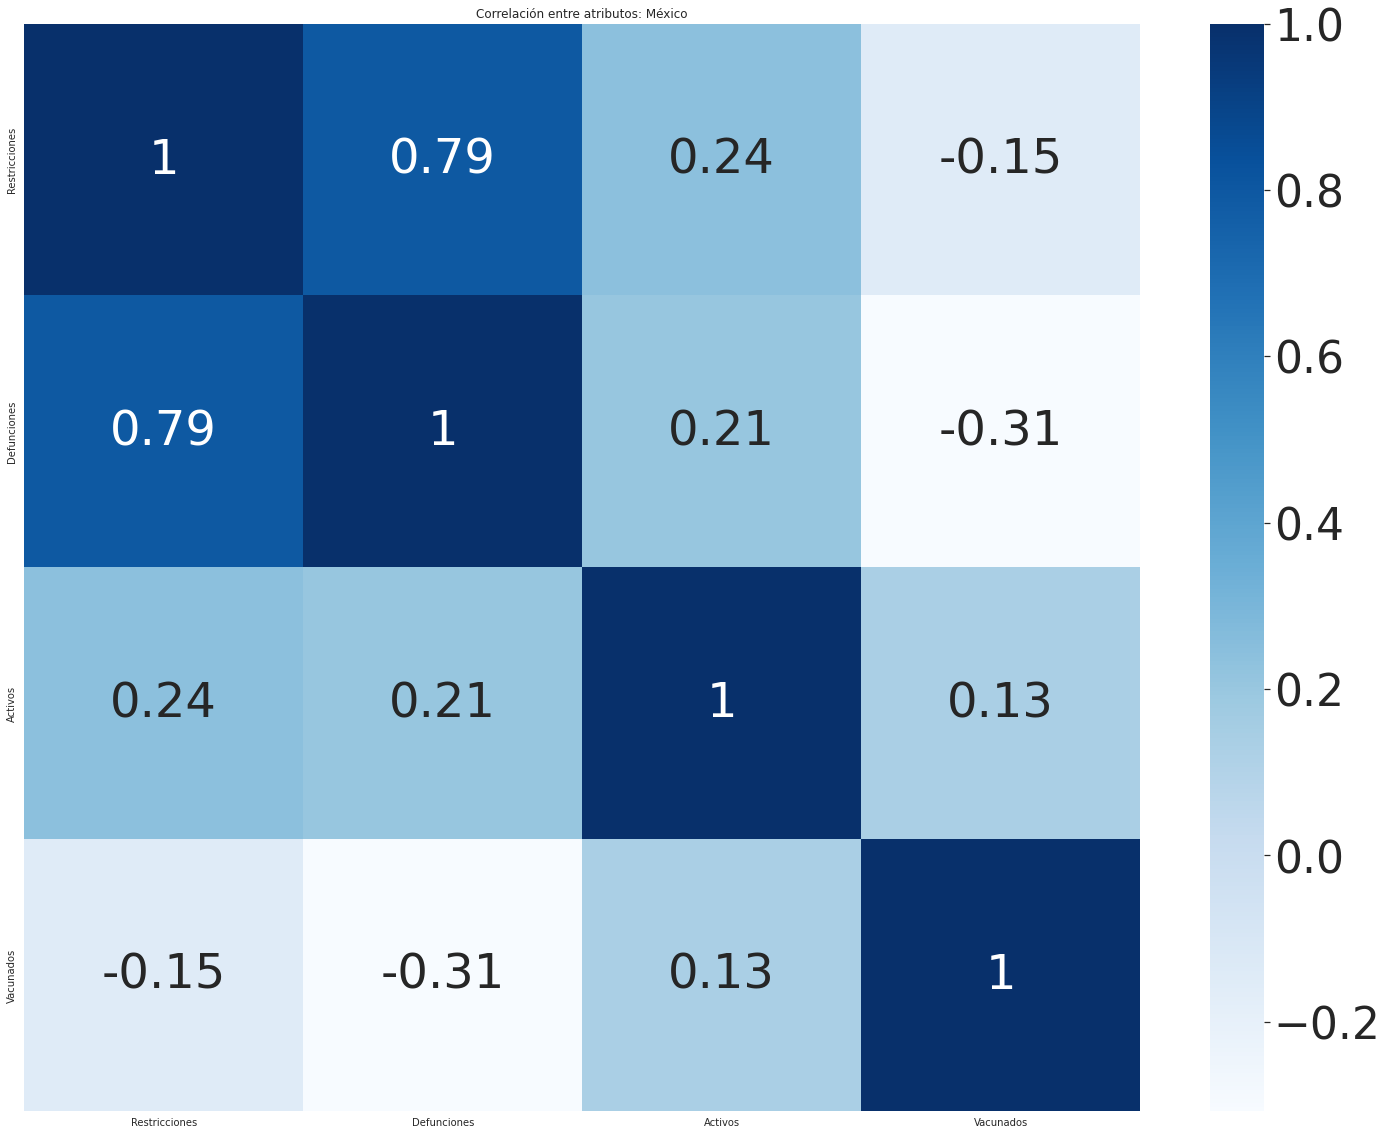

In [ ]:
#@title Correlación de variables y las restricciones en México
corrmex = covidrestmex1[['stringency_index', 'Defunciones', 'Activos', 'Vacunados']]
corrmex.rename(columns = {'stringency_index': 'Restricciones'}, inplace=True)
corr = corrmex.corr(method='pearson')


plt.figure(figsize = (25, 20))
ax = plt.axes()
ax.set_title('Correlación entre atributos: México')

sns.set(font_scale=4)
sns.heatmap(corr, cmap="Blues", annot=True, fmt='.2g')
sns.color_palette("light:b", as_cmap=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


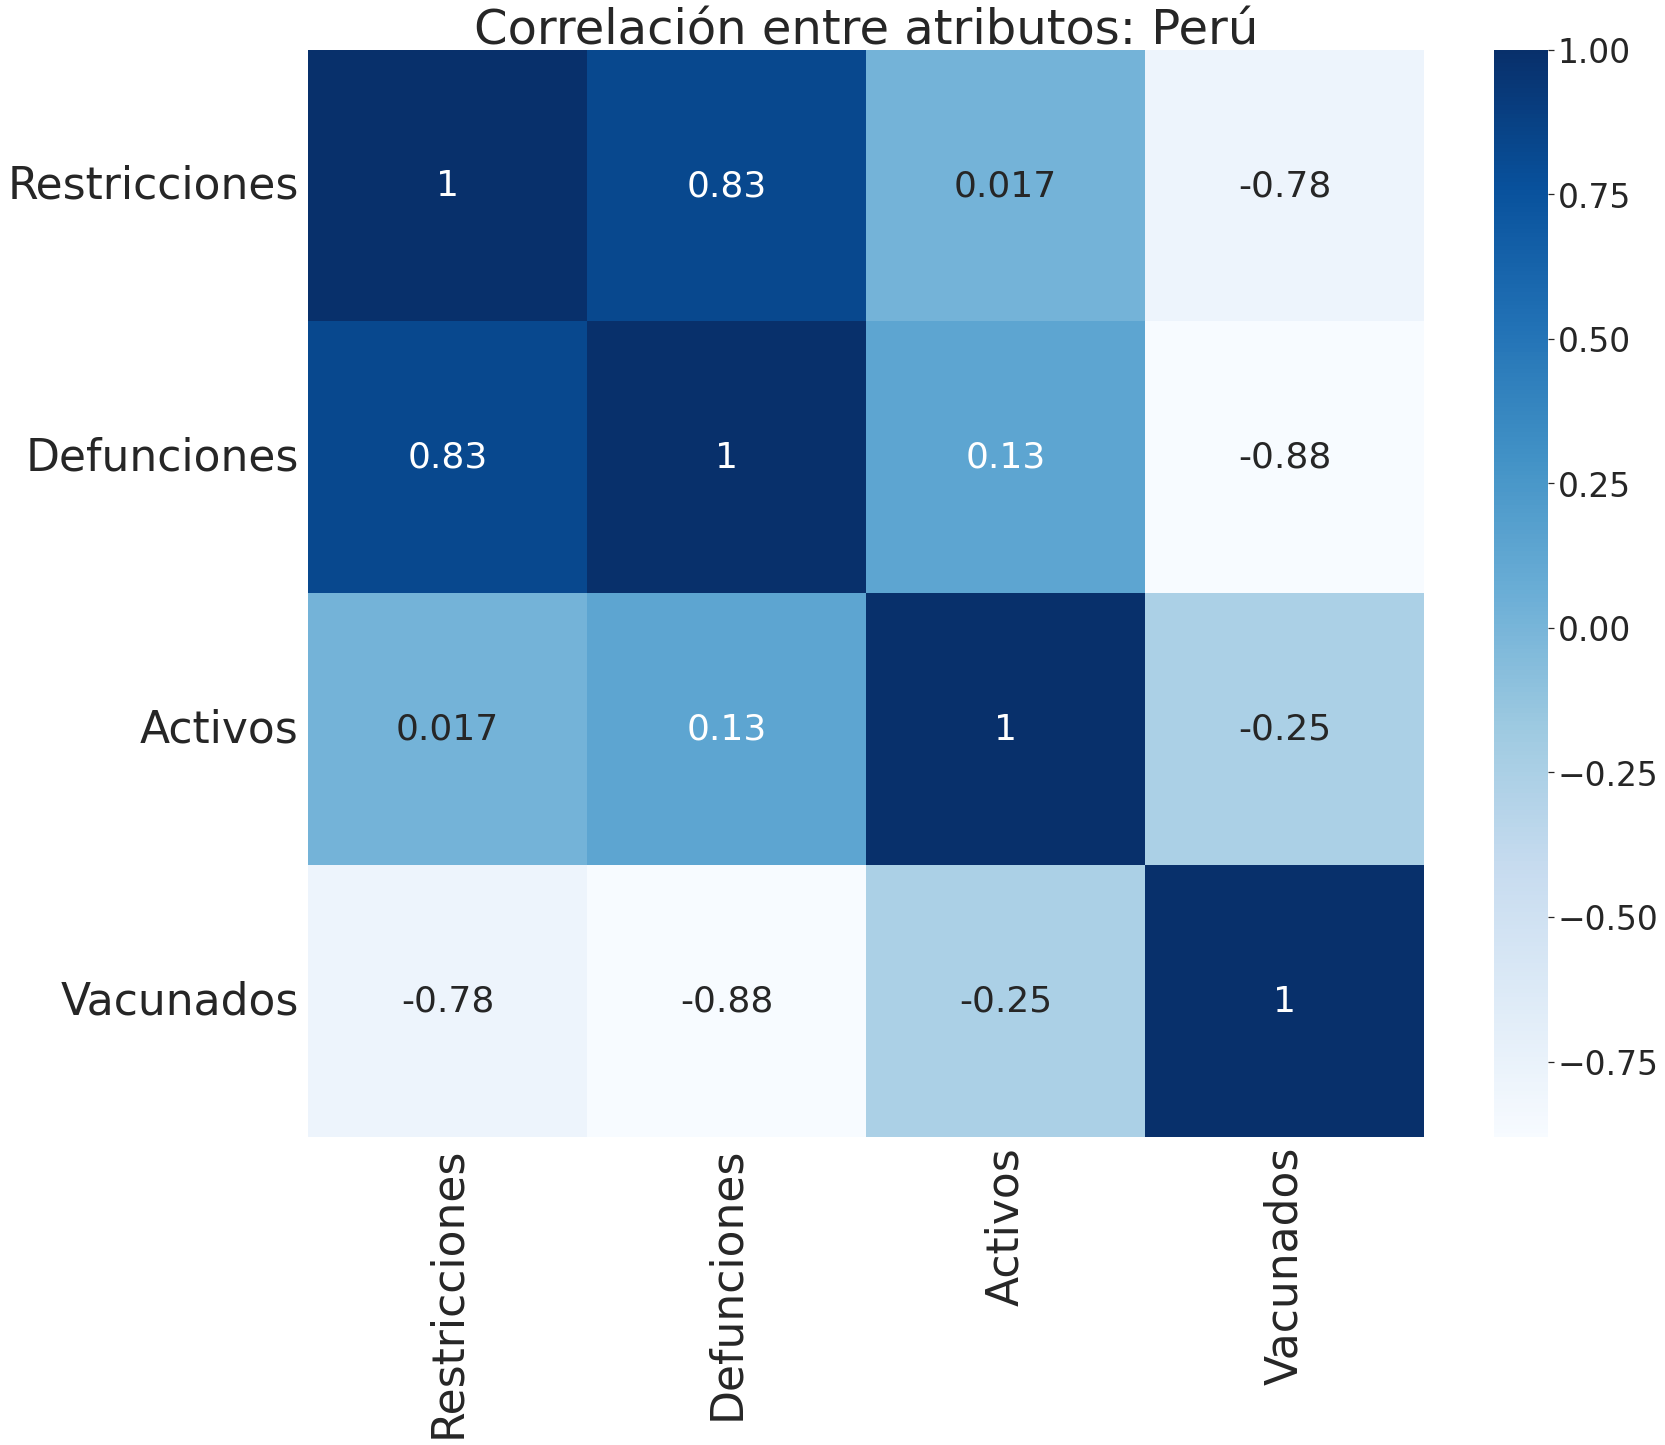

In [ ]:
#@title Correlación de variables y las restricciones en Perú
corrper = covidrestper[['stringency_index', 'Defunciones', 'Activos', 'Vacunados']]
corrper.rename(columns = {'stringency_index': 'Restricciones'}, inplace=True)
corr = corrper.corr(method='pearson')


plt.figure(figsize = (25, 20))
ax = plt.axes()
ax.set_title('Correlación entre atributos: Perú')

sns.set(font_scale=3)
sns.heatmap(corr, cmap="Blues", annot=True, fmt='.2g')
sns.color_palette("light:b", as_cmap=True)
plt.show()